In [19]:
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.io import imread
from sklearn.externals import joblib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import os
import glob
import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def generate_pos_train(file_path):

    # configuration
    orientations = 9
    pixels_per_cell = [5, 5]
    cells_per_block = [3, 3]
    visualize = False
    normalize = True

    min_h = 50
    min_w = 50

    for im_path in glob.glob(os.path.join(file_path, '*rgb.png')):
        im = Image.open(im_path)
        im = im.convert('L')
        im = np.asarray(im.resize((min_h, min_w)))
        fd = hog(im, orientations, 
                 pixels_per_cell, cells_per_block, 
                 visualize, normalize)
        
        yield fd

In [3]:
plt.imshow(hog_img)
plt.show()

NameError: name 'hog_img' is not defined

In [21]:
def generate_neg_train(file_path):

    # configuration
    orientations = 9
    pixels_per_cell = [5, 5]
    cells_per_block = [3, 3]
    visualize = False
    normalize = True
    
    min_h = 50
    min_w = 50

    for im_path in glob.glob(os.path.join(file_path, '*')):
        im = Image.open(im_path)
        im = im.convert('L')
        w_im, h_im = im.size[0], im.size[1]
        im = np.asarray(im)
        for h in range(h_im // min_h):
            for w in range(w_im // min_w):
                crop_im = im[min_h*h:min_h*(h+1), min_w*w:min_w*(w+1)]
                fd = hog(crop_im, orientations, 
                         pixels_per_cell, cells_per_block, 
                         visualize, normalize)
                
                yield fd

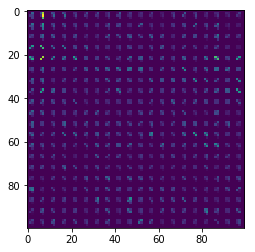

In [98]:
plt.imshow(hog_img)
plt.show()

# SVM classifier

In [22]:
current_path = os.getcwd()
pos_train_path_1 = os.path.join(current_path, 'Datasets', 'Plant', 'Ara2013-RPi')
pos_train_path_2 = os.path.join(current_path, 'Datasets', 'Plant', 'Ara2013-Canon')
pos_train_path_3 = os.path.join(current_path, 'Datasets', 'Plant', 'Ara2012')

In [23]:
neg_train_path = os.path.join(current_path, 'Datasets', 'Negative')

In [24]:
fds = []
labels = []

for pos_example in generate_pos_train(pos_train_path_1):
    fds.append(pos_example)
    labels.append(1)
    
for pos_example in generate_pos_train(pos_train_path_2):
    fds.append(pos_example)
    labels.append(1)
    
for pos_example in generate_pos_train(pos_train_path_3):
    fds.append(pos_example)
    labels.append(1)

In [25]:
for neg_example in generate_neg_train(neg_train_path):
    fds.append(neg_example)
    labels.append(0)

In [26]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    fds, labels, test_size=0.2, random_state=0)

clf = LinearSVC()
clf.fit(X_train, y_train)
print('train accuracy: ', clf.score(X_train, y_train))
print('test accuracy: ', clf.score(X_test, y_test))

train accuracy:  1.0
test accuracy:  0.986631016043


# Object Detection

In [27]:
def sliding_window(image, window_size, step_size):
    '''
    This function returns a patch of the input image `image` of size equal
    to `window_size`. The first image returned top-left co-ordinates (0, 0) 
    and are increment in both x and y directions by the `step_size` supplied.
    So, the input parameters are -
    * `image` - Input Image
    * `window_size` - Size of Sliding Window
    * `step_size` - Incremented Size of Window
    The function returns a tuple -
    (x, y, im_window)
    where
    * x is the top-left x co-ordinate
    * y is the top-left y co-ordinate
    * im_window is the sliding window image
    '''
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [28]:
def nms(detections, threshold=.5):
    '''
    This function performs Non-Maxima Suppression.
    `detections` consists of a list of detections.
    Each detection is in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    If the area of overlap is greater than the `threshold`,
    the area with the lower confidence score is removed.
    The output is a list of detections.
    '''
    if len(detections) == 0:
        return []
    # Sort the detections based on confidence score
    detections = sorted(detections, key=lambda detections: detections[2],
            reverse=True)
    # Unique detections will be appended to this list
    new_detections=[]
    # Append the first detection
    new_detections.append(detections[0])
    # Remove the detection from the original list
    del detections[0]
    # For each detection, calculate the overlapping area
    # and if area of overlap is less than the threshold set
    # for the detections in `new_detections`, append the 
    # detection to `new_detections`.
    # In either case, remove the detection from `detections` list.
    for index, detection in enumerate(detections):
        for new_detection in new_detections:
            if overlapping_area(detection, new_detection) > threshold:
                del detections[index]
                break
        else:
            new_detections.append(detection)
            del detections[index]
    return new_detections

In [29]:
def overlapping_area(detection_1, detection_2):
    '''
    Function to calculate overlapping area'si
    `detection_1` and `detection_2` are 2 detections whose area
    of overlap needs to be found out.
    Each detection is list in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    The function returns a value between 0 and 1,
    which represents the area of overlap.
    0 is no overlap and 1 is complete overlap.
    Area calculated from ->
    http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
    '''
    # Calculate the x-y co-ordinates of the 
    # rectangles
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

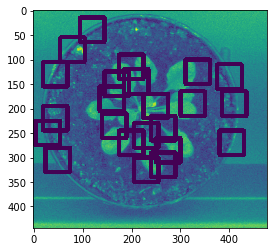

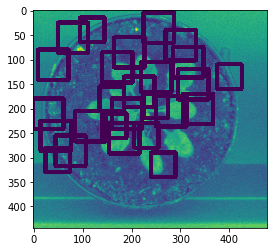

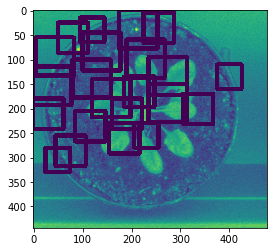

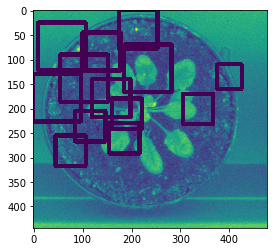

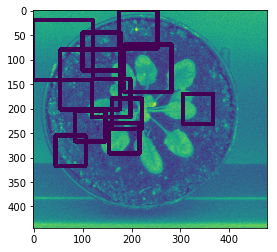

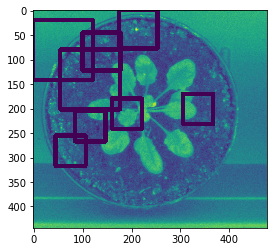

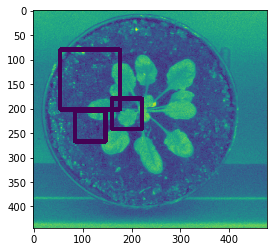

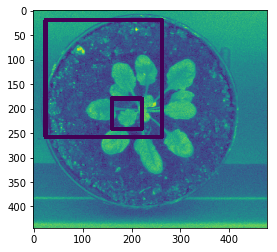

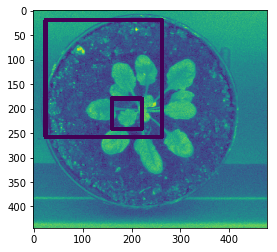

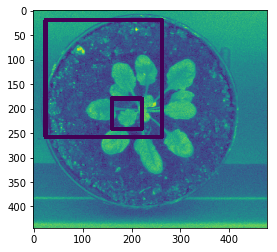

In [31]:
from skimage.transform import pyramid_gaussian
import cv2

min_window_size = (50, 50)
step_size = (5, 5)
downscale = 1.25
visualize_det = False
threshold = 0.2

detections = []
scale = 0

orientations = 9
pixels_per_cell = [5, 5]
cells_per_block = [3, 3]
visualize = False
normalize = True

img_path = os.path.join(current_path, 'Datasets', 'Stacks', 'Ara2012', 'stack_04', 'ara2012_plant04_frame01_rgb.png')
im = imread(img_path, as_grey=True)

for im_scaled in pyramid_gaussian(im, downscale=downscale):
    cd = []
    if im_scaled.shape[0] < min_window_size[0] or im_scaled.shape[1] < min_window_size[1]:
        break
    for (x, y, im_window) in sliding_window(im_scaled, min_window_size, step_size):
            if im_window.shape[0] != min_window_size[1] or im_window.shape[1] != min_window_size[0]:
                continue
            # Calculate the HOG features
            fd = hog(im_window, orientations, pixels_per_cell, cells_per_block, visualize, normalize)
            fd = fd.reshape((1, -1))
            pred = clf.predict(fd)
            if pred == 1:
#                 print("Detection:: Location -> ({}, {})".format(x, y))
#                 print("Scale ->  {} | Confidence Score {} \n".format(scale,clf.decision_function(fd)))
                detections.append((x, y, clf.decision_function(fd),
                    int(min_window_size[0]*(downscale**scale)),
                    int(min_window_size[1]*(downscale**scale))))
                cd.append(detections[-1])

    # Move the the next scale
    scale+=1

    # Display the results before performing NMS
    clone = im.copy()

    # Perform Non Maxima Suppression
    detections = nms(detections, threshold)

    # Display the results after performing NMS
    for (x_tl, y_tl, _, w, h) in detections:
        # Draw the detections
        cv2.rectangle(clone, (x_tl, y_tl), (x_tl+w,y_tl+h), (0, 0, 0), thickness=8)
    
    plt.imshow(clone)
    plt.show()